In [3]:
!pip install mediapipe
!pip install ipython==7.32.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 18.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
from scipy.interpolate import interp1d ,PchipInterpolator

In [2]:
mp_face_mesh = mp.solutions.face_mesh



def extract_forehead(frame, face_landmarks, image_w, image_h):
    forehead_indices = [10, 338, 297, 332, 284, 251, 389, 356, 454, 323]
    coords = np.array([
        [int(face_landmarks.landmark[i].x * image_w),
         int(face_landmarks.landmark[i].y * image_h)]
        for i in forehead_indices
    ])
    x, y, w, h = cv2.boundingRect(coords)
    roi = frame[y:y + h, x:x + w]

    # ✅ Extract only green channel
    green_channel = roi[:, :, 1]  # (H, W)

    # ✅ Resize and normalize
    roi_resized = cv2.resize(green_channel, (32, 32)) / 255.0  # (64, 64)

    # ✅ Add channel axis (for CNN input)
    roi_resized = roi_resized[..., np.newaxis]  # Shape: (64, 64, 1)

    return roi_resized


In [3]:
# video_path = "/content/drive/MyDrive/UBFC_DATASET/DATASET_1/5-gt/vid.avi"
# csv_path = "/content/gt1.csv"

# X, y = preprocess_sample(video_path, csv_path, 2000)
# print(X.shape)  # (300, 64, 64, 3)
# print(y.shape)  # (300,)


import matplotlib.pyplot as plt

def plot_interpolation(csv_path, frame_timestamps_ms, target_bpm):
    # Original data
    df = pd.read_csv(csv_path)
    original_times = df['Timestep (ms)'].values
    original_bpm = df['Heart rate (HR)'].values

    plt.figure(figsize=(10, 5))
    plt.plot(original_times, original_bpm, 'bo-', label='Original BPM (from CSV)')
    plt.plot(frame_timestamps_ms, target_bpm, 'r.-', label='Interpolated BPM (per frame)')
    plt.xlabel("Time (ms)")
    plt.ylabel("BPM")
    plt.title("Heart Rate Interpolation over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [4]:


def preprocess_sample(video_path, csv_path, num_frames):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_duration = total_frames / fps

    # num_frames = int(target_fps * duration_sec)
    # df = pd.read_csv(csv_path)
    df = pd.read_csv(csv_path, usecols=[0, 1])
    # df.rename(columns={"Timestep (ms)": "milliseconds", "Heart rate (HR)": "bpm"}, inplace=True)

    times_ms = df['Timestep (ms)'].values
    bpm_values = df['Heart rate (HR)'].values

    f_interp = interp1d(times_ms, bpm_values, kind='cubic', fill_value="extrapolate")
    # f_interp = PchipInterpolator(times_ms, bpm_values)
    frames = []
    frame_timestamps_ms = []
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1)

    while cap.isOpened() and len(frames) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break

        timestamp = cap.get(cv2.CAP_PROP_POS_MSEC)
        image_h, image_w = frame.shape[:2]

        results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks:
            roi = extract_forehead(frame, results.multi_face_landmarks[0], image_w, image_h)
            frames.append(roi)
        else:
            # fallback to blank frame
            frames.append(np.zeros((32, 32, 1), dtype=np.uint8))

        frame_timestamps_ms.append(timestamp)

    cap.release()
    face_mesh.close()

    # Padding if shorter than num_frames
    while len(frames) < num_frames:
        frames.append(frames[-1])
        frame_timestamps_ms=np.append(frame_timestamps_ms, frame_timestamps_ms[-1])

    # Interpolate BPM at frame timestamps
    target_bpm = f_interp(frame_timestamps_ms)
    plot_interpolation(csv_path, frame_timestamps_ms, target_bpm)


    return np.array(frames), np.array(target_bpm)

In [6]:
# def load_dataset(base_path="UBFC", num_frames=2000):
#     X, Y = [], []

#     for subject in tqdm(os.listdir(base_path)):
#         subject_path = os.path.join(base_path, subject)
#         video_path = os.path.join(subject_path, "video.avi")
#         csv_path = os.path.join(subject_path, "ground_truth.csv")

#         if os.path.exists(video_path) and os.path.exists(csv_path):
#             try:
#                 x, y = preprocess_sample(video_path, csv_path, num_frames=num_frames)
#                 X.append(x)
#                 Y.append(y)
#             except Exception as e:
#                 print(f"Error in {subject}: {e}")

#     return np.array(X), np.array(Y)


import os
import numpy as np
from tqdm import tqdm  # Optional if you want progress bar

def load_dataset(num_frames=2000):
    X, Y = [], []

    # Hardcoded paths for 2 samples
    samples = [
        ("/content/drive/MyDrive/DATASET_1/5-gt/vid.avi", "/content/gt1.csv"),
        ("/content/drive/MyDrive/DATASET_1/6-gt/vid.avi", "/content/gt2.csv"),
        ("/content/drive/MyDrive/DATASET_1/after-exercise/vid.avi", "/content/gt7.csv"),
        ("/content/drive/MyDrive/DATASET_1/7-gt/vid.avi", "/content/gt3.csv"),
        ("/content/drive/MyDrive/DATASET_1/10-gt/vid.avi", "/content/gt4.csv"),
        ("/content/drive/MyDrive/DATASET_1/11-gt/vid.avi", "/content/gt5.csv"),
        ("/content/drive/MyDrive/DATASET_1/12-gt/vid.avi", "/content/gt6.csv"),

    ]

    for video_path, csv_path in samples:
        if os.path.exists(video_path) and os.path.exists(csv_path):
            try:
                x, y = preprocess_sample(video_path, csv_path, num_frames=num_frames)
                X.append(x)
                Y.append(y)
            except Exception as e:
                print(f"Error in sample {video_path}: {e}")
        else:
            print(f"Missing file: {video_path} or {csv_path}")

    return np.array(X), np.array(Y)


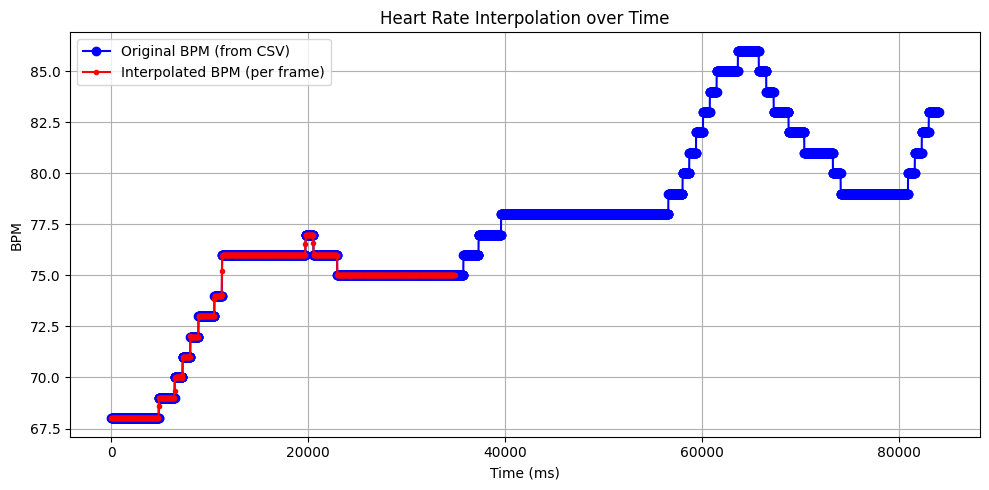

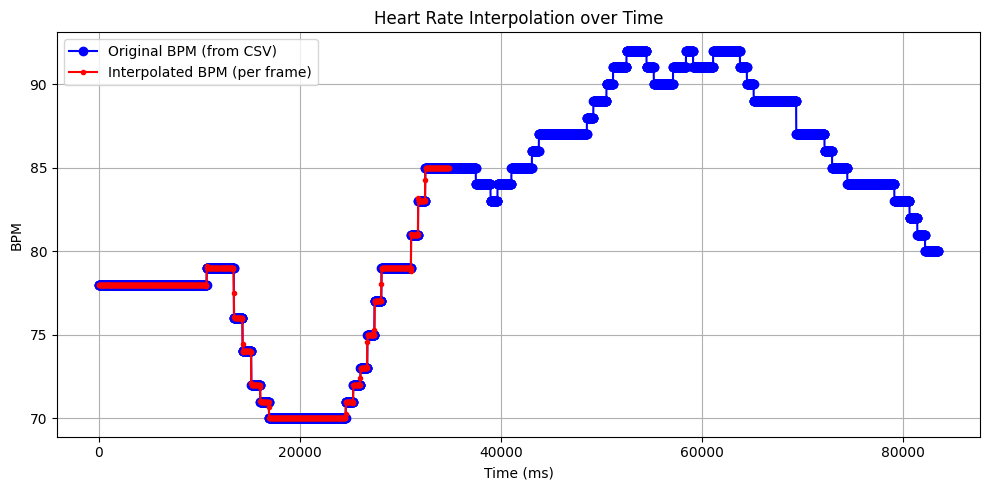

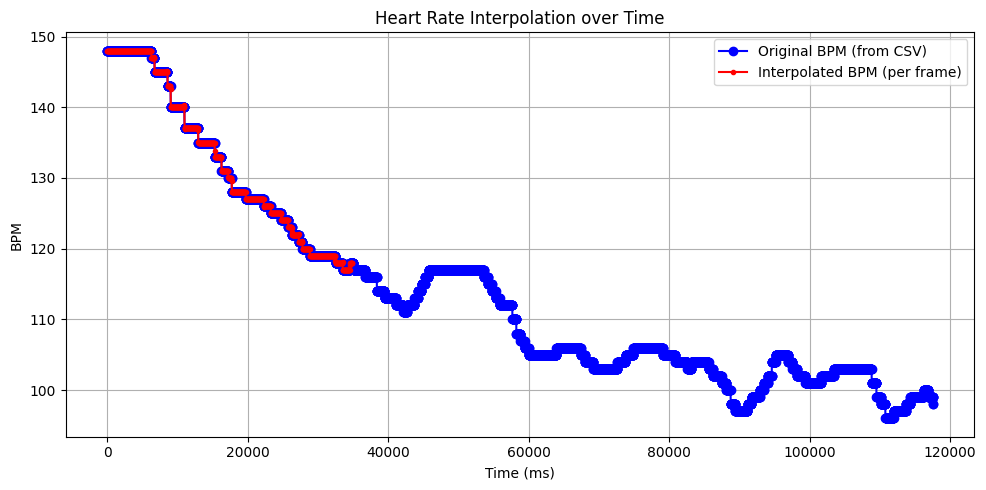

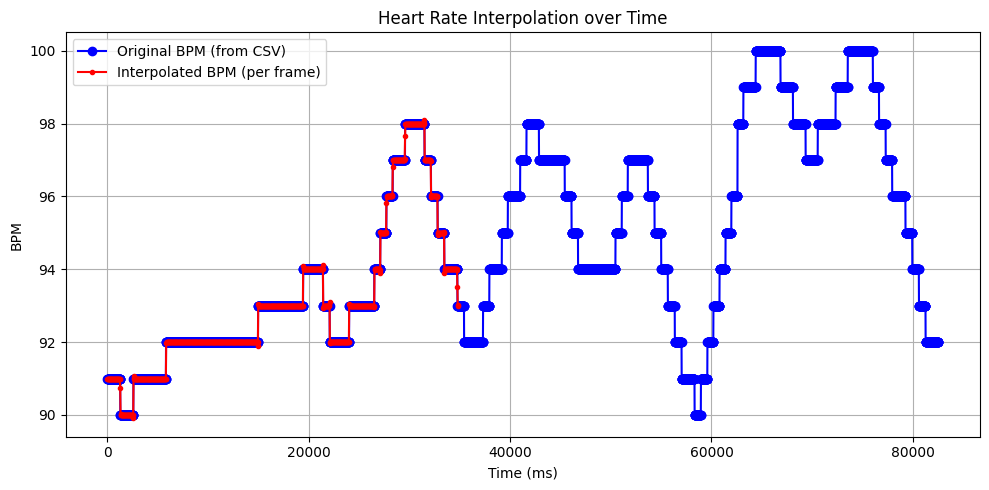

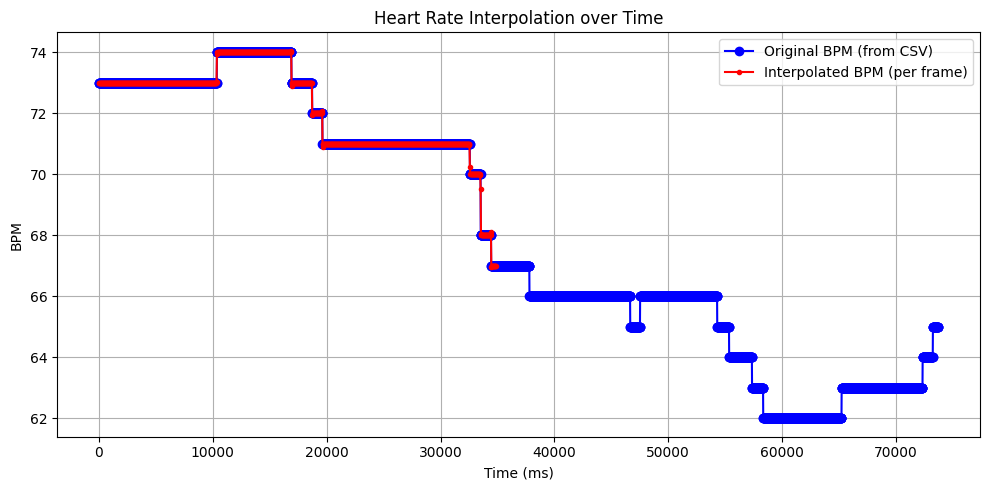

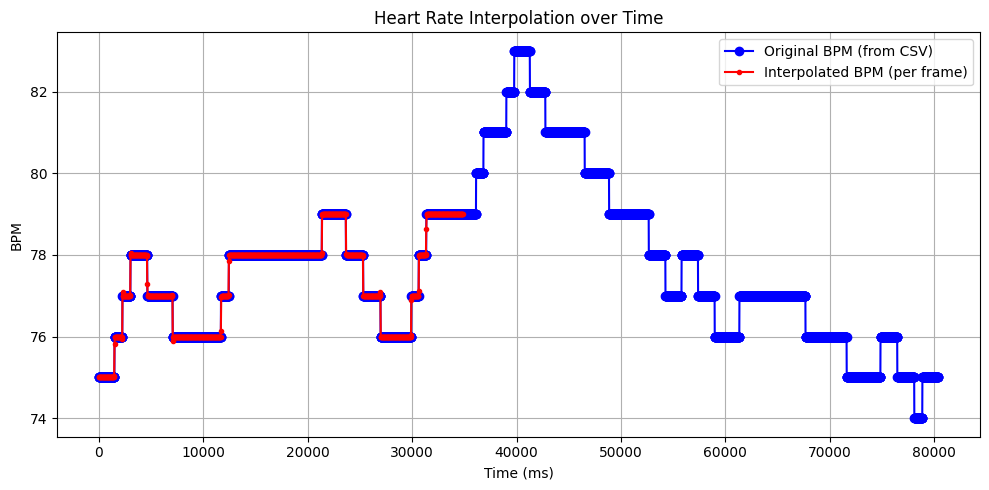

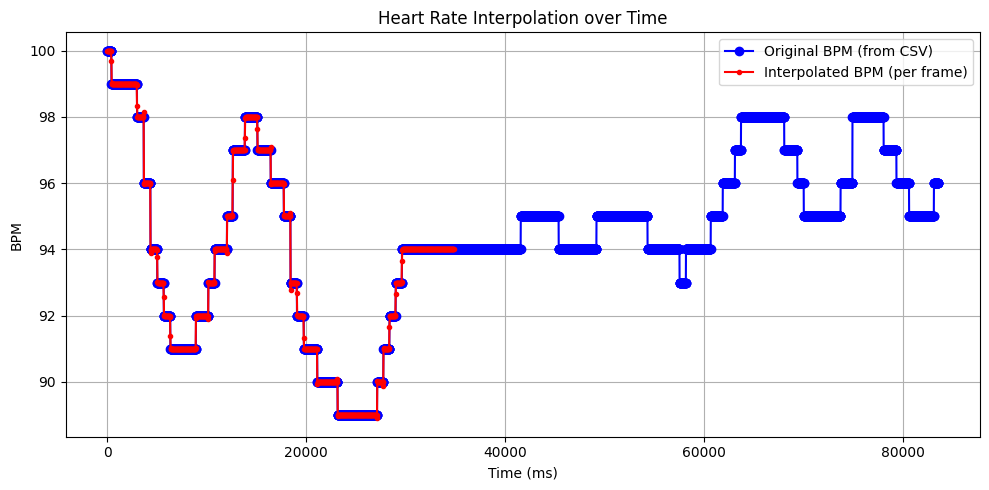

In [7]:
# X, Y = load_dataset(base_path="UBFC", num_frames=2000)

ip, op = load_dataset(num_frames=1000)



In [8]:
X = np.array(ip)
Y = np.array(op)[..., np.newaxis]

In [9]:
X.shape , Y.shape

((7, 1000, 32, 32, 1), (7, 1000, 1))

In [11]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 588.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 118.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.5 MB/s eta 0:00:00


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout, BatchNormalization

def build_model(num_frames=1000, height=32, width=32, channels=1):
    input_layer = Input(shape=(num_frames, height, width, channels))


    cnn = TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'))(input_layer)
    cnn = TimeDistributed(MaxPooling2D((2, 2)))(cnn)
    cnn = TimeDistributed(BatchNormalization())(cnn)

    cnn = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(cnn)
    cnn = TimeDistributed(MaxPooling2D((2, 2)))(cnn)
    cnn = TimeDistributed(BatchNormalization())(cnn)

    cnn = TimeDistributed(Flatten())(cnn)

    lstm = LSTM(32, return_sequences=True)(cnn)
    lstm = Dropout(0.2)(lstm)

    output = TimeDistributed(Dense(1, activation='linear'))(lstm)

    model = Model(inputs=input_layer, outputs=output)
    return model


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = build_model(num_frames=1000, height=32, width=32, channels=1)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()


callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

model.fit(X, Y, batch_size=4, epochs=20, validation_split=0.2 , callbacks=callbacks)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1000, 32, 32,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1000, 32, 32,   │           160 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 1000, 16, 16,   │             0 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 1000, 16, 16,   │            64 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 1000, 16, 16,   │         4,640 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 1000, 8, 8, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 1000, 8, 8, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 1000, 2048)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1000, 32)       │       266,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 1000, 1)        │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,393 (1.04 MB)

 Trainable params: 271,297 (1.03 MB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1730s 269s/step - loss: 8743.1465 - mae: 90.4337 - val_loss: 7123.8970 - val_mae: 83.9213 - learning_rate: 0.0010
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 778s 128s/step - loss: 8193.0547 - mae: 87.2798 - val_loss: 6777.6870 - val_mae: 81.8516 - learning_rate: 0.0010
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 782s 129s/step - loss: 8115.4487 - mae: 86.8818 - val_loss: 6851.5762 - val_mae: 82.2607 - learning_rate: 0.0010
Epoch 4/20


In [ ]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=7, shuffle=True, random_state=42)

all_fold_mae = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n🔁 Fold {fold + 1}")

    X_train, X_val = X[train_idx], X[val_idx]
    Y_train, Y_val = Y[train_idx], Y[val_idx]


    model = build_model(num_frames=1000, height=32, width=32, channels=1)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Fit model
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=5,
        batch_size=2,
        callbacks=callbacks,
        verbose=1
    )

    val_mae = history.history['val_mae'][-1]
    all_fold_mae.append(val_mae)

print(f"\n✅ Average MAE across folds: {np.mean(all_fold_mae):.4f}")



🔁 Fold 1
Epoch 1/5


KeyboardInterrupt: 

Archive:  dummy.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of dummy.zip or
        dummy.zip.zip, and cannot find dummy.zip.ZIP, period.
